# Notebook to train CNNs

In [2]:
import tensorflow as tf
import os

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

# Load libraries
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import math
import time
from pathlib import Path
from Resnet3D_model import Resnet3DBuilder
from sklearn.metrics import balanced_accuracy_score, f1_score, matthews_corrcoef, accuracy_score, recall_score
from data_utils import get_paths_and_labels, calculate_min_max, create_dataset, clean_zone_identifier_files, extract_subject_id
from plotting_utils import view_image, view_random_image, plot_loss_curves, make_confusion_matrix, view_image_data
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedGroupKFold
import gc

1 Physical GPUs, 1 Logical GPUs


In [2]:
# Set seeds for reproducibility
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
# Set mixed precision policy to 'mixed_float16'
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)
print('Mixed precision policy set to:', policy.name)

Mixed precision policy set to: mixed_float16


In [4]:
NORMALIZATION = "mni_reg_CV" # Choose intensity normalization method: "minmax"
DATASET = "smci_pmci" # Choose dataset: "smci_pmci" or "nc_ad"
DATA_DIR = Path("/home/diogommiranda/tese/datasets/") / NORMALIZATION / DATASET
VOLUME_SHAPE = (91, 109, 91) # Expected volume shape of the PET images
BATCH_SIZE = 4 # Set batch size

USE_MASK = True # Set to True to use the ROI mask, False to use the whole brain

if USE_MASK:
    ROI_MASK_PATH = str(Path("/home/diogommiranda/tese/masks/ROI_MASK.nii"))
else:
    ROI_MASK_PATH = None

# Get train paths and labels to calculate minmax values
train_paths, train_labels_list, class_map = get_paths_and_labels(DATA_DIR, 'train')
train_paths = np.array(train_paths)
train_labels = np.array(train_labels_list)

# Calculate minmax values for train set
minmax_min, minmax_max = calculate_min_max(train_paths)

# Create train dataset
train_data = create_dataset(
    paths=train_paths,
    labels=train_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=True,
    seed=seed,
    min_val=minmax_min, 
    max_val=minmax_max, 
    mask_path=ROI_MASK_PATH
    )

# Create test set with the minmax values from train
test_paths, test_labels, _ = get_paths_and_labels(DATA_DIR, 'test', class_map=class_map)
test_data = create_dataset(
    paths=test_paths,
    labels=test_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=False,
    seed=None,
    min_val=minmax_min, 
    max_val=minmax_max,
    mask_path=ROI_MASK_PATH
    )

Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci/train...
Found 575 files for class 'smci'
Found 314 files for class 'pmci'
Calculating minmax across 889 files...
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
Shuffling with buffer size: 889

Applying mask from /home/diogommiranda/tese/masks/ROI_MASK.nii

Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci/test...
Found 143 files for class 'smci'
Found 78 files for class 'pmci'

Applying mask from /home/diogommiranda/tese/masks/ROI_MASK.nii



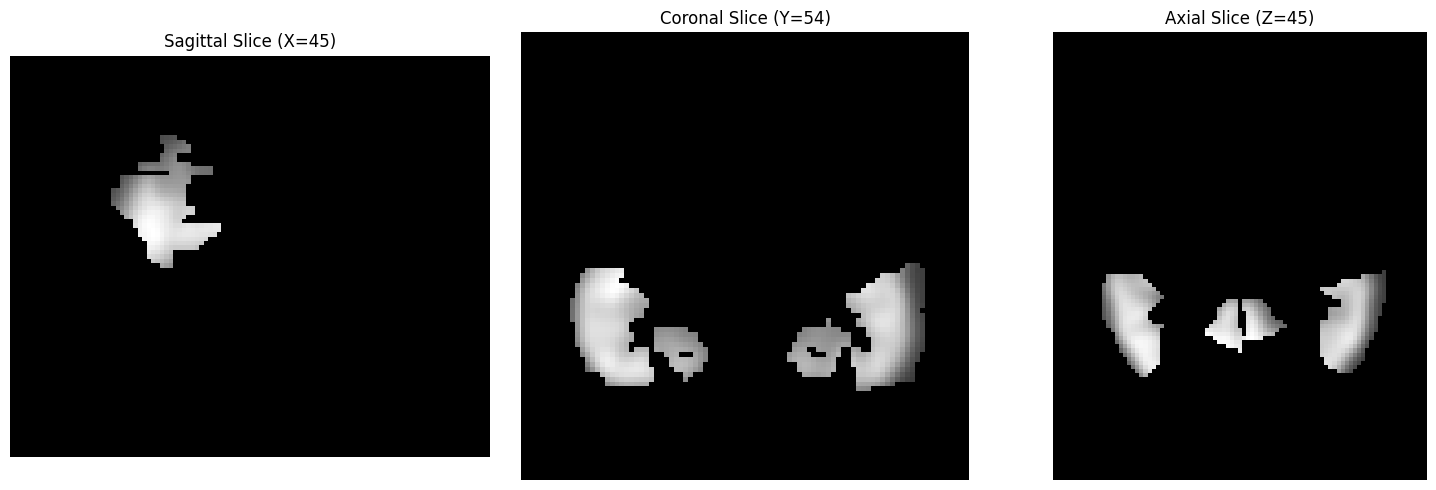

In [5]:
# Verify data with a test sample
for data, label in test_data:
    view_image_data(data[0])
    break

In [ ]:
# ----- Hyperparameter Tuning with K-Fold Cross-Validation -----

N_SPLITS = 5 # Number of splits for cross-validation
NUM_EPOCHS = 100 # Number of epochs for training
DROPOUT_RATE = 0.0 # Dropout rate for the model

# para cosine decay
#learning_rates_to_try = [5e-4, 2e-4, 1e-4] # adicionar 1e-3? ver os resultados
#reg_factors_to_try = [5e-4, 2e-4, 1e-4]

#para fixed_lr
#learning_rates_to_try = [1e-5, 2e-5] # adicionar 4e-5 ou 5e-6 dependendo dos resultados
#reg_factors_to_try = [2e-4, 1e-4] # adicionar 4e-4 ou 5e-5 dependendo dos resultados

lr_scheduler = "fixed_lr" # Choose between "cosine_decay" or "fixed_lr"

learning_rates_to_try = [1.1e-5]
reg_factors_to_try = [2e-4]

tuning_results = []
total_combinations = len(learning_rates_to_try) * len(reg_factors_to_try)
current_combination_no = 0

if ROI_MASK_PATH is None:
    if lr_scheduler == "cosine_decay":
        RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/full_brain/cosine_decay/CROSS_VALIDATION/results_resnet34/"
    elif lr_scheduler == "fixed_lr":
        RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/full_brain/fixed_lr/CROSS_VALIDATION/results_resnet34/"
    else:
        raise ValueError("Invalid string for 'lr_scheduler'. Please set it to 'cosine_decay' or 'fixed_lr'.")
    os.makedirs(RESULTS_BASE_DIR, exist_ok=True)
    print(f"Results will be saved to: {RESULTS_BASE_DIR}")
else:
    if lr_scheduler == "cosine_decay":
        RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/masked/cosine_decay/CROSS_VALIDATION/results_resnet34/"
    elif lr_scheduler == "fixed_lr":
        RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/masked/fixed_lr/CROSS_VALIDATION/results_resnet34/"
    else:
        raise ValueError("Invalid string for 'lr_scheduler'. Please set it to 'cosine_decay' or 'fixed_lr'.")
    os.makedirs(RESULTS_BASE_DIR, exist_ok=True)
    print(f"Results will be saved to: {RESULTS_BASE_DIR}")

# Set up StratifiedGroupKFold by subjects
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)
subject_ids_list = [extract_subject_id(p) for p in train_paths]
subject_ids = np.array(subject_ids_list)

print("\nStarting Hyperparameter Tuning Grid Search...")
overall_start_time = time.time()

# Hyperparameter tuning loop
for current_lr in learning_rates_to_try:
    for current_reg in reg_factors_to_try:
        current_combination_no += 1
        print("=" * 60)
        print(f"Testing Combination {current_combination_no}/{total_combinations}: LR={current_lr:.1e}, L2_Reg={current_reg:.0e}")
        print("=" * 60)
        start_time_combination = time.time()
        
        combo_dir_name = f"LR0_{current_lr:.1e}_L2_{current_reg:.0e}"
        combo_results_dir = os.path.join(RESULTS_BASE_DIR, combo_dir_name)
        os.makedirs(combo_results_dir, exist_ok=True)
        print(f"  Saving results for this combo to: {combo_results_dir}")
        
        # Store results for the current hyperparameter combination
        current_combo_losses = []
        current_combo_accuracies = []
        current_combo_aucs = []
        current_combo_best_epoch = []

        # Store results for each fold
        fold_val_losses = []
        fold_val_accuracies = []
        fold_val_aucs = []
        fold_no = 1

        # K-Fold Cross-Validation
        for train_indices, val_indices in sgkf.split(train_paths, train_labels, groups=subject_ids):
            print("-" * 60)
            print(f"Training Fold {fold_no}/{N_SPLITS} for LR={current_lr:.1e} and Reg={current_reg:.0e}...")
            start_time_fold = time.time()

            # Get the paths and labels for the current fold
            fold_train_paths = train_paths[train_indices]
            fold_train_labels = train_labels[train_indices]
            fold_val_paths = train_paths[val_indices]
            fold_val_labels = train_labels[val_indices]

            # Verify that the training and validation sets have no overlapping subjects
            train_subjects = set(subject_ids[train_indices])
            val_subjects = set(subject_ids[val_indices])
            if not train_subjects.isdisjoint(val_subjects):
                raise RuntimeError(f"WARNING: Fold {fold_no} has overlapping subjects!")
                
            print(f"  Train samples: {len(fold_train_paths)}, Validation samples: {len(fold_val_paths)}")

            # Calculate minmax parameters for the current training fold
            fold_min, fold_max = calculate_min_max(fold_train_paths)

            # Create fold train dataset
            fold_train_data = create_dataset(
                paths=fold_train_paths,
                labels=fold_train_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=True, 
                seed=seed,
                min_val=fold_min, 
                max_val=fold_max,
                mask_path=ROI_MASK_PATH
            )
            
            # Create fold validation dataset
            fold_val_data = create_dataset(
                paths=fold_val_paths,
                labels=fold_val_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=False, 
                seed=None,
                min_val=fold_min, 
                max_val=fold_max,
                mask_path=ROI_MASK_PATH
            )

            if fold_train_data is None or fold_val_data is None:
                raise RuntimeError(f"ERROR: Could not create datasets for fold {fold_no}.")

            # Compute class weights for the current fold
            unique_classes, class_counts = np.unique(fold_train_labels, return_counts=True)
            print(f"  Fold train label counts: {dict(zip(unique_classes, class_counts))}")
            fold_class_weights = class_weight.compute_class_weight('balanced', classes=unique_classes, y=fold_train_labels)
            fold_class_weight_dict = dict(zip(unique_classes, fold_class_weights))
            print(f"  Fold Class Weights: {fold_class_weight_dict}")

            tf.keras.backend.clear_session()
            # Build the model
            model = Resnet3DBuilder.build_resnet_34((91, 109, 91, 1), 1, reg_factor=current_reg, dropout_rate=DROPOUT_RATE)
    
            # Cosine decay scheduler
            steps_per_epoch = math.ceil(len(fold_train_data) / BATCH_SIZE)
            decay_steps = steps_per_epoch * NUM_EPOCHS
            COSINE_ALPHA_FACTOR = 1e-6/current_lr # Alpha factor for cosine decay: finishes last epoch (NUM_EPOCHS) in 1e-6
            cosine_decay = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=current_lr,
                                                                     decay_steps=decay_steps,
                                                                     alpha=COSINE_ALPHA_FACTOR,
                                                                     name='CosineDecay')
            
            if lr_scheduler == "cosine_decay":
                # Use cosine decay
                optimizer_lr = cosine_decay
                EARLY_STOP_PATIENCE = 20 # we use 20 to mitigate the effect of lucky steps at the beginning of the cosine decay
            elif lr_scheduler == "fixed_lr":
                # Use fixed learning rate
                optimizer_lr = current_lr
                EARLY_STOP_PATIENCE = 10 # we use 10 because with lower learning rates the model converges with more stability
            else:
                raise ValueError("Invalid string for 'lr_scheduler'. Please set it to 'cosine_decay' or 'fixed_lr'.")
            
            early_stopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                patience=EARLY_STOP_PATIENCE,
                                                restore_best_weights=True,
                                                verbose=1)
    
            callbacks_list = [early_stopper]

            auc_metric = tf.keras.metrics.AUC(name='auc')

            # Compile the model
            model.compile(loss="binary_crossentropy",
                          optimizer= tf.keras.optimizers.Adam(learning_rate=optimizer_lr, clipnorm=1.0),
                          metrics=["accuracy", auc_metric])

            history = model.fit(
                fold_train_data,
                epochs=NUM_EPOCHS,
                validation_data=fold_val_data,
                class_weight=fold_class_weight_dict,
                verbose=1,
                callbacks=callbacks_list
            )
            
            # Save the data for current fold
            fold_dir = os.path.join(combo_results_dir, f"fold_{fold_no}")
            os.makedirs(fold_dir, exist_ok=True)
            history_df = pd.DataFrame(history.history)
            history_df.insert(0, 'epoch', range(1, len(history_df) + 1))
            history_csv_path = os.path.join(fold_dir, f"history_fold_{fold_no}.csv")
            try:
                history_df.to_csv(history_csv_path, index=False)
                print(f"  History saved to: {history_csv_path}")
            except Exception as e:
                print(f"  Error saving history: {e}")
            # Save plots
            plot_loss_curves(history, fold_dir)

            # Evaluate the fold
            best_epoch_index = np.argmin(history.history['val_loss'])
            best_epoch = best_epoch_index + 1
            val_loss_best = history.history['val_loss'][best_epoch_index]
            val_accuracy_best = history.history['val_accuracy'][best_epoch_index]
            val_auc_best = history.history['val_auc'][best_epoch_index]
            print(f"    Fold {fold_no} - Best Epoch {best_epoch}: Val Loss={val_loss_best:.4f}, Acc={val_accuracy_best:.4f}, AUC={val_auc_best:.4f}")
    
            current_combo_losses.append(val_loss_best)
            current_combo_accuracies.append(val_accuracy_best)
            current_combo_aucs.append(val_auc_best)
            current_combo_best_epoch.append(best_epoch)

            # Clean up
            del history_df
            del history 
            del fold_train_data
            del fold_val_data
            del model
            tf.keras.backend.clear_session()
            gc.collect()

            end_time_fold = time.time()
            print(f"    Fold {fold_no} finished in {end_time_fold - start_time_fold:.2f} seconds.")
            fold_no += 1

        # Aggregate results for the current hyperparameter combination
        if len(current_combo_losses) == N_SPLITS:
            avg_loss = np.mean(current_combo_losses)
            std_loss = np.std(current_combo_losses)
            avg_acc = np.mean(current_combo_accuracies)
            std_acc = np.std(current_combo_accuracies)
            avg_auc = np.mean(current_combo_aucs)
            std_auc = np.std(current_combo_aucs)

            print("-" * 50)
            print(f"Results for LR={current_lr}, L2_Reg={current_reg} (Across {N_SPLITS} Folds):")
            print(f"  Avg Val Loss: {avg_loss:.4f} +/- {std_loss:.4f}")
            print(f"  Avg Val Acc:  {avg_acc:.4f} +/- {std_acc:.4f}")
            print(f"  Avg Val AUC:  {avg_auc:.4f} +/- {std_auc:.4f}")
            print("-" * 50)
            

            # Store results
            tuning_results.append({
                'learning_rate': current_lr,
                'reg_factor': current_reg,
                'avg_val_loss': avg_loss,
                'std_val_loss': std_loss,
                'avg_val_accuracy': avg_acc,
                'std_val_accuracy': std_acc,
                'avg_val_auc': avg_auc,
                'std_val_auc': std_auc,
                'individual_losses': [round(loss, 4) for loss in current_combo_losses],
                'individual_accuracies': [round(acc, 4) for acc in current_combo_accuracies],
                'individual_aucs': [round(auc, 4) for auc in current_combo_aucs],
                'best_epoch_per_fold': list(current_combo_best_epoch)
            })

        end_time_combination = time.time()
        print(f"Combination {current_combination_no} finished in {end_time_combination - start_time_combination:.2f} seconds.") 


Results will be saved to: /home/diogommiranda/tese/outputs/masked/fixed_lr/CROSS_VALIDATION/results_resnet34/

Starting Hyperparameter Tuning Grid Search...
Testing Combination 1/1: LR=1.1e-05, L2_Reg=2e-04
  Saving results for this combo to: /home/diogommiranda/tese/outputs/masked/fixed_lr/CROSS_VALIDATION/results_resnet34/LR0_1.1e-05_L2_2e-04
------------------------------------------------------------
Training Fold 1/5 for LR=1.1e-05 and Reg=2e-04...
  Train samples: 706, Validation samples: 183
Calculating minmax across 706 files...
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
Shuffling with buffer size: 706

Applying mask from /home/diogommiranda/tese/masks/ROI_MASK.nii


Applying mask from /home/diogommiranda/tese/masks/ROI_MASK.nii

  Fold train label counts: {0: 456, 1: 250}
  Fold Class Weights: {0: 0.7741228070175439, 1: 1.412}
here CHANNELS last
Epoch 1/100


I0000 00:00:1745822929.573554 1681620 service.cc:145] XLA service 0x7ff2d0005660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745822929.573768 1681620 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-04-28 07:48:53.632319: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-28 07:48:57.824438: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1745822951.112729 1681620 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_32', 536 bytes spill stores, 536 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_31', 280 bytes spill stores, 280 bytes spill loads
ptxas warning : Registers are spilled to local memory i

176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7293 - auc: 0.7231 - loss: 3.8329

I0000 00:00:1745822976.701711 1681619 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_32', 48 bytes spill stores, 48 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_28', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_29', 4 bytes spill stores, 4 bytes spill loads



177/177 ━━━━━━━━━━━━━━━━━━━━ 66s 184ms/step - accuracy: 0.7297 - auc: 0.7242 - loss: 3.8318 - val_accuracy: 0.3497 - val_auc: 0.7559 - val_loss: 4.6668
Epoch 2/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.8540 - auc: 0.9110 - loss: 3.5342 - val_accuracy: 0.3497 - val_auc: 0.7358 - val_loss: 5.7540
Epoch 3/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.8830 - auc: 0.9470 - loss: 3.4153 - val_accuracy: 0.3770 - val_auc: 0.7092 - val_loss: 4.6886
Epoch 4/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.9304 - auc: 0.9734 - loss: 3.3226 - val_accuracy: 0.3497 - val_auc: 0.7265 - val_loss: 5.5025
Epoch 5/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - accuracy: 0.9453 - auc: 0.9846 - loss: 3.2400 - val_accuracy: 0.6230 - val_auc: 0.7621 - val_loss: 4.0548
Epoch 6/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.9549 - auc: 0.9851 - loss: 3.1946 - val_accuracy: 0.7650 - val_auc: 0.6849 - val_loss: 4.3954
Epoch 7/100
177/177 ━━━━━━━━━━━━━

2025-04-28 09:32:08.341764: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19111968 bytes after encountering the first element of size 19111968 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.9889 - auc: 0.9861 - loss: 2.8848 - val_accuracy: 0.6936 - val_auc: 0.8668 - val_loss: 3.5967
Epoch 16/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.9623 - auc: 0.9845 - loss: 2.9331 - val_accuracy: 0.5549 - val_auc: 0.8668 - val_loss: 4.2312
Epoch 17/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.9886 - auc: 0.9946 - loss: 2.8110 - val_accuracy: 0.6358 - val_auc: 0.8723 - val_loss: 4.0911
Epoch 18/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.9862 - auc: 0.9958 - loss: 2.7850 - val_accuracy: 0.6879 - val_auc: 0.8773 - val_loss: 3.6407
Epoch 19/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 2.7023 - val_accuracy: 0.6012 - val_auc: 0.8666 - val_loss: 3.9238
Epoch 20/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.9959 - auc: 0.9985 - loss: 2.6847 - val_accuracy: 0.5954 - val_auc: 0.7877 - val_loss: 4.6756
Epoch 21/100
179/179 ━━━━━━━━

2025-04-28 09:35:38.353874: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 14442528 bytes after encountering the first element of size 14442528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.9992 - auc: 1.0000 - loss: 2.3401 - val_accuracy: 0.6936 - val_auc: 0.8842 - val_loss: 3.3238
Epoch 31/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 2.3034 - val_accuracy: 0.8092 - val_auc: 0.8921 - val_loss: 2.7837
Epoch 32/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.9987 - auc: 1.0000 - loss: 2.2774 - val_accuracy: 0.6821 - val_auc: 0.8488 - val_loss: 3.4684
Epoch 33/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 2.2353 - val_accuracy: 0.5723 - val_auc: 0.8539 - val_loss: 3.8568
Epoch 34/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.9992 - auc: 0.9944 - loss: 2.2083 - val_accuracy: 0.7630 - val_auc: 0.8825 - val_loss: 2.8476
Epoch 35/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 1.0000 - auc: 0.9944 - loss: 2.1651 - val_accuracy: 0.7803 - val_auc: 0.8908 - val_loss: 2.8375
Epoch 36/100
179/179 ━━━━━━━━

2025-04-28 09:40:16.913520: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 16777248 bytes after encountering the first element of size 16777248 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.6867 - val_accuracy: 0.7514 - val_auc: 0.8953 - val_loss: 2.3479
Epoch 51/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.6510 - val_accuracy: 0.7168 - val_auc: 0.8684 - val_loss: 2.4610
Epoch 52/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.6162 - val_accuracy: 0.6532 - val_auc: 0.8236 - val_loss: 3.2144
Epoch 53/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.9723 - auc: 0.9944 - loss: 1.6637 - val_accuracy: 0.7052 - val_auc: 0.9139 - val_loss: 2.4785
Epoch 54/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.9897 - auc: 0.9930 - loss: 1.6069 - val_accuracy: 0.5896 - val_auc: 0.8456 - val_loss: 3.0970
Epoch 55/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.5619 - val_accuracy: 0.8324 - val_auc: 0.8967 - val_loss: 2.0683
Epoch 56/100
179/179 ━━━━━━━━

In [ ]:
print("=" * 60)
if not tuning_results:
    print("No tuning results were recorded.")
else:
    
    results_df = pd.DataFrame(tuning_results)
    results_df = results_df.sort_values(by='avg_val_loss', ascending=True)

    print("\nTuning Results Summary:")
    display_cols = ['learning_rate', 'reg_factor', 'avg_val_loss', 'avg_val_accuracy', 'avg_val_auc', 'std_val_loss', 'std_val_accuracy', 'std_val_auc', 'individual_losses', 'individual_accuracies', 'individual_aucs', 'best_epoch_per_fold']
    print(results_df[display_cols].round(4))

    best_combination = results_df.iloc[0]

    print("\n --- Best Hyperparameters Found ---")
    print(best_combination[display_cols])

    best_lr_final = best_combination['learning_rate']
    best_reg_final = best_combination['reg_factor']
    print(f"\nSelected best parameters: LR={best_lr_final:.1e}, L2_Reg={best_reg_final:.0e}")


Tuning Results Summary:
   learning_rate  reg_factor  avg_val_loss  avg_val_accuracy  avg_val_auc  \
0            0.0      0.0002        1.7938            0.7878       0.8357   

   std_val_loss  std_val_accuracy  std_val_auc  \
0        0.2854            0.0481       0.0594   

                          individual_losses  \
0  [2.1326, 2.1467, 1.6278, 1.5638, 1.4981]   

                    individual_accuracies  \
0  [0.7268, 0.733, 0.8232, 0.8409, 0.815]   

                           individual_aucs    best_epoch_per_fold  
0  [0.748, 0.7827, 0.8831, 0.8663, 0.8985]  [91, 99, 97, 99, 100]  

 --- Best Hyperparameters Found ---
learning_rate                                            0.000011
reg_factor                                                 0.0002
avg_val_loss                                             1.793826
avg_val_accuracy                                         0.787775
avg_val_auc                                              0.835703
std_val_loss                  

# --- Train the model with the best hyperparameters and evaluate it on the test set ---

In [6]:
if ROI_MASK_PATH is None:
    print("\nUsing full brain scan.\n")
else:
    print("\nUsing ROI mask.\n")


Using full brain scan.



here CHANNELS last

Using fixed learning rate: 1.1e-05

Saving model to: /home/diogommiranda/tese/outputs/best_model.weights.h5
  Class Weights: {0: 0.7730434782608696, 1: 1.4156050955414012}
Epoch 1/50


I0000 00:00:1746445093.154095    1982 service.cc:145] XLA service 0x7fef140016a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746445093.154151    1982 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-05-05 12:38:13.874067: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-05 12:38:16.633609: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-05-05 12:38:21.563183: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 9.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
I0000 00:00:1746445113.781611    1982 asm_compiler.cc:369] ptxas warning : Registers ar

222/223 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7319 - auc: 0.7148 - loss: 3.8363

2025-05-05 12:38:50.731167: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 9.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
I0000 00:00:1746445142.057882    1983 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_372__5', 12 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_359__8', 2424 bytes spill stores, 2376 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm70_shflsync_down', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_34', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'inpu

223/223 ━━━━━━━━━━━━━━━━━━━━ 66s 141ms/step - accuracy: 0.7324 - auc: 0.7159 - loss: 3.8352
Epoch 2/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 33s 143ms/step - accuracy: 0.8636 - auc: 0.9249 - loss: 3.5053
Epoch 3/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9461 - auc: 0.9882 - loss: 3.2726
Epoch 4/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 17s 64ms/step - accuracy: 0.9478 - auc: 0.9825 - loss: 3.2550
Epoch 5/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.9673 - auc: 0.9944 - loss: 3.1527
Epoch 6/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.9785 - auc: 0.9940 - loss: 3.1074
Epoch 7/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9731 - auc: 0.9752 - loss: 3.1654
Epoch 8/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.9811 - auc: 0.9947 - loss: 3.0285
Epoch 9/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.9796 - auc: 0.9957 - loss: 2.9819
Epoch 10/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - accuracy: 0.9859 - auc: 0.9940 - l

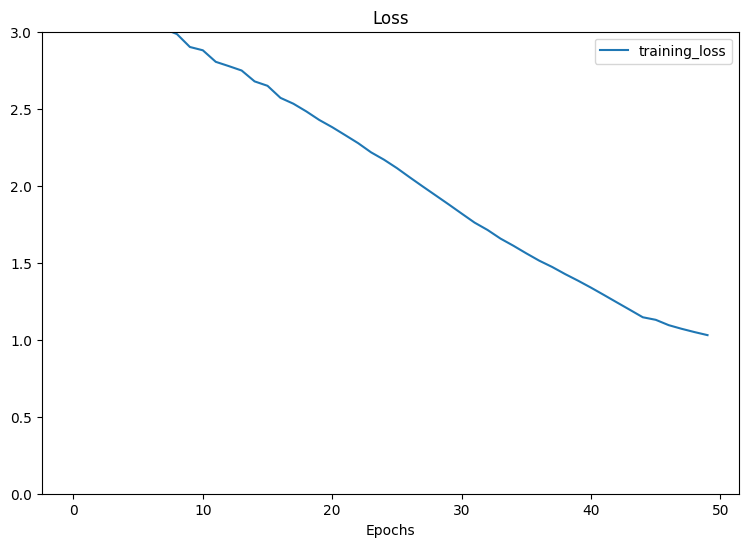

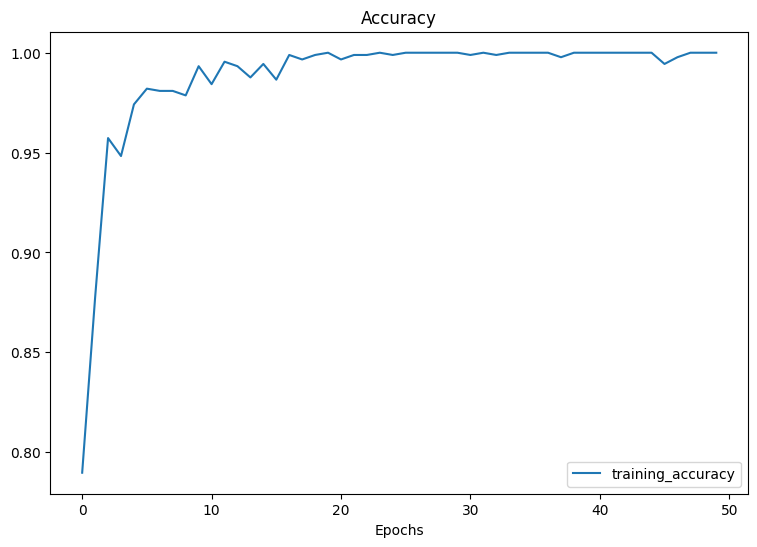

In [7]:
# --- Train the model with the best hyperparameters and evaluate it on the test set ---

cosine_scheduler = False # Set to True if using cosine decay, False if using fixed learning rate

train_for_more_epochs = False
BEST_NUM_EPOCHS = 50 # number of epochs for training

# Hyperparameters
BEST_LR = 1.1e-5 # learning rate
BEST_REG= 2e-4 # l2 regularization factor

# Cosine decay parameters
DECAY_STEPS_TO_USE = math.ceil(len(train_data) / BATCH_SIZE) * 100 # 100 epochs (used in cross-validation for cosine decay)
BEST_ALPHA_FACTOR =  1e-6 / BEST_LR
DROPOUT_RATE = 0.0
cosine_decay = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=BEST_LR,
                                                        decay_steps=DECAY_STEPS_TO_USE,
                                                        alpha=BEST_ALPHA_FACTOR,
                                                        name='CosineDecay')


model = Resnet3DBuilder.build_resnet_34((91, 109, 91, 1), 1, reg_factor=BEST_REG, dropout_rate=DROPOUT_RATE)
if train_for_more_epochs:
    model.load_weights("/home/diogommiranda/tese/outputs/best_model.weights.h5") # load model to continue training for more epochs
    print(f"\nLoading model weights to continue training for more epochs.")
        

if cosine_scheduler:
    # Use cosine decay
    optimizer_lr = cosine_decay
    print(f"\nUsing cosine decay.\n")
else:
    # Use fixed learning rate
    optimizer_lr = BEST_LR
    print(f"\nUsing fixed learning rate: {BEST_LR}\n")

auc_metric = tf.keras.metrics.AUC(name='auc')

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=optimizer_lr,
                                                     clipnorm=1.0),
                metrics=["accuracy", auc_metric])


# Only save the model if not using cosine decay
if not cosine_scheduler:
    check_point_filepath = "/home/diogommiranda/tese/outputs/best_model.weights.h5"
    print(f"Saving model to: {check_point_filepath}")
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=check_point_filepath,
        save_weights_only=True,
        monitor='loss',
        mode='min',
        save_best_only=False)
    callbacks = [model_checkpoint_callback]
else:
    callbacks = None

# Compute class weights
unique_classes, class_counts = np.unique(train_labels, return_counts=True)
class_weights = class_weight.compute_class_weight('balanced', classes=unique_classes, y=train_labels)
class_weight_dict = dict(zip(unique_classes, class_weights))
print(f"  Class Weights: {class_weight_dict}")

history = model.fit(
    train_data,
    epochs=BEST_NUM_EPOCHS,
    class_weight=class_weight_dict,
    verbose=1,
    callbacks=callbacks,
)

# Plot loss and accuracy curves
plot_loss_curves(history)

result = model.evaluate(test_data, return_dict=True)
print(f"[{result['loss']}, {result['accuracy']}]")


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step


2025-05-05 12:50:23.676547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



--- Evaluation Metrics on Test Set ---
Accuracy:    0.8190
Sensitivity: 0.6026
Specificity: 0.9371 
Balanced Accuracy (BACC): 0.7698
F1 Score (Weighted):      0.8106
Matthews Corr Coef (MCC): 0.5929
Area Under the Curve (AUC): 0.8294



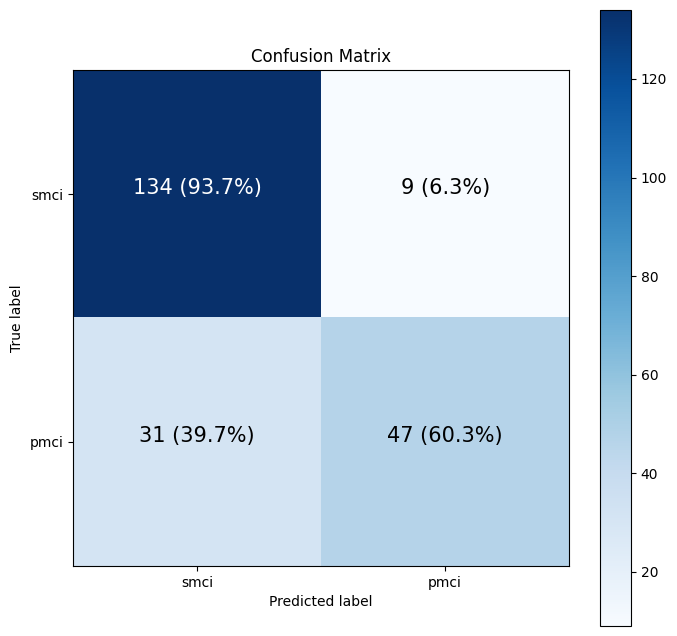

In [8]:
# Predict on the test set
y_pred = model.predict(test_data).flatten()

# --- Print evaluation metrics ---
y_true = []
test_samples = []
for sample, label in test_data.as_numpy_iterator():
    test_samples.append(sample)
    y_true.append(label)
y_true = np.concatenate(y_true)


test_samples = np.concatenate(test_samples, axis=0)
y_true_int = y_true.astype(int)
y_pred_int = y_pred.round().astype(int)

accuracy = accuracy_score(y_true_int, y_pred_int)
sensitivity = recall_score(y_true_int, y_pred_int, pos_label=1)
specificity = recall_score(y_true_int, y_pred_int, pos_label=0)
bacc = balanced_accuracy_score(y_true_int, y_pred_int)
f1 = f1_score(y_true_int, y_pred_int, average='weighted')
mcc = matthews_corrcoef(y_true_int, y_pred_int)

auc_score = result.get('auc')

print("\n--- Evaluation Metrics on Test Set ---")
print(f"Accuracy:    {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f} ")
print(f"Balanced Accuracy (BACC): {bacc:.4f}")
print(f"F1 Score (Weighted):      {f1:.4f}") 
print(f"Matthews Corr Coef (MCC): {mcc:.4f}")
print(f"Area Under the Curve (AUC): {auc_score:.4f}\n")

# --- Plot confusion matrix ---
class0, class1 = DATASET.split("_")
target_names = [class0, class1]

make_confusion_matrix(y_true=y_true,
                      y_pred=y_pred.round(),
                      classes=target_names,
                      figsize=(8, 8),
                      text_size=15)



# Save the model

In [ ]:
save_option = False # Set to True to save the model, confusion matrix, and evaluation metrics

if save_option:
    
    # Configure the right path
    if USE_MASK:
        dir1 = "masked/"
    else:
        dir1 = "full_brain/"
    if cosine_scheduler:
        dir2 = "cosine_decay/"
    else:
        dir2 = "fixed_lr/"
        
    save_model_dir = "/home/diogommiranda/tese/outputs/" + dir1 + dir2 + "CROSS_VALIDATION/saved_models/" + f"LR={BEST_LR:.1e}_L2={BEST_REG:.0e}"
    print(f"Saving model to: {save_model_dir}")
    os.makedirs(save_model_dir, exist_ok=True)

    # Save the model
    model.save(os.path.join(save_model_dir, "model.keras"))

    # Save the confusion matrix plot
    make_confusion_matrix(y_true=y_true,
                        y_pred=y_pred.round(),
                        classes=target_names,
                        figsize=(8, 8),
                        text_size=15,
                        save_dir=save_model_dir)

    # Save the test loss and accuracy and the evaluation metrics
    result_file_path = os.path.join(save_model_dir, "resultados.txt")
    with open(result_file_path, "w") as f:
        f.write(f"[{result['loss']}, {result['accuracy']}]\n\n")
        f.write("--- Evaluation Metrics on Test Set ---\n")
        f.write(f"Accuracy:    {accuracy:.4f}\n")
        f.write(f"Sensitivity: {sensitivity:.4f}\n")
        f.write(f"Specificity: {specificity:.4f}\n")
        f.write(f"Balanced Accuracy (BACC): {bacc:.4f}\n")
        f.write(f"F1 Score (Weighted):      {f1:.4f}\n")
        f.write(f"Matthews Corr Coef (MCC): {mcc:.4f}\n")
        f.write(f"Area Under the Curve (AUC): {auc_score:.4f}\n")

Saving model to: /home/diogommiranda/tese/outputs/masked/fixed_lr/CROSS_VALIDATION/saved_models/LR=1.1e-05_L2=2e-04


In [ ]:
#saved_model = tf.keras.models.load_model("/home/diogommiranda/tese/outputs/full_brain/fixed_lr/CROSS_VALIDATION/saved_models/LR=1.1e-5 L2=2e-4/model.keras")

In [ ]:
#result = saved_model.evaluate(test_data, return_dict=True)
#print(f"[{result['loss']}, {result['accuracy']}]")


56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - accuracy: 0.8917 - auc: 0.3368 - loss: 1.7163
[1.964396357536316, 0.8461538553237915]
